-------------------------------------------------------------------------------------------------------------------------------------------------

Okay, I'm **done** with spark. "---The iloc[] equivalent to pandas (collect()) is broken and seems to be taking forever to run, the timezone is messed up and the "timestamp" data type doesn't match properly with datetime(), so there is no way to precisely see data outside of 2019 nor there is a way to filter out specific dates to find out weekdays/weekends and public holidays, nor there is an accurate way to see day vs night.---"  (rage quit moment, don't read if time is valuable)

Moving on to the ol' reliable pandas.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

## Trip Duration

In [3]:
pdf = pd.read_parquet("../data/raw/yellow/2019-01.parquet")  # pdf = parquet data frame

# drop useless columns
pdf = pdf.drop(columns=["VendorID", "passenger_count", "RatecodeID", "store_and_fwd_flag", "payment_type", "fare_amount", "extra", "mta_tax" ,\
    "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"])
# filter out non-2019 data
pdf = pdf[pdf["tpep_dropoff_datetime"] > datetime(2018, 12, 31)]
pdf = pdf[pdf["tpep_pickup_datetime"] < datetime(2020, 1, 1)]
pdf.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.5,151,239
1,2019-01-01 00:59:47,2019-01-01 01:18:59,2.6,239,246
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.3,163,229
8,2019-01-01 00:32:01,2019-01-01 00:45:39,3.7,229,7
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.1,141,234


In [4]:
# find out the trip duration
pdf["trip_duration"] = pdf["tpep_dropoff_datetime"] - pdf["tpep_pickup_datetime"]
# in minutes (float)
pdf["trip_duration"] = pdf["trip_duration"] / np.timedelta64(1, "m")
pdf.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.5,151,239,6.666667
1,2019-01-01 00:59:47,2019-01-01 01:18:59,2.6,239,246,19.200000
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.3,163,229,7.150000
8,2019-01-01 00:32:01,2019-01-01 00:45:39,3.7,229,7,13.633333
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.1,141,234,12.000000


## Speed

In [5]:
# find out the average speed of each trip (miles/minute)
pdf["avg_speed"] = pdf["trip_distance"] / pdf["trip_duration"]
pdf.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,trip_duration,avg_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.5,151,239,6.666667,0.225000
1,2019-01-01 00:59:47,2019-01-01 01:18:59,2.6,239,246,19.200000,0.135417
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.3,163,229,7.150000,0.181818
8,2019-01-01 00:32:01,2019-01-01 00:45:39,3.7,229,7,13.633333,0.271394
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.1,141,234,12.000000,0.175000


Before proceeding any further, we must first see and assess outliers, because I *know* there will be outliers in this big messy data.

In [6]:
pdf2 = pdf.copy()
pdf2 = pdf2.sort_values("avg_speed", ascending=True)
print(pdf2.head(3))
pdf2.tail(3)

        tpep_pickup_datetime tpep_dropoff_datetime  trip_distance  \
4741746  2019-01-20 15:15:30   2019-01-18 15:57:16            1.9   
2517596  2019-01-11 19:24:47   2019-01-11 19:24:49            0.0   
2332498  2019-01-11 08:10:07   2019-01-11 08:10:15            0.0   

         PULocationID  DOLocationID  trip_duration  avg_speed  
4741746           186           162   -2838.233333  -0.000669  
2517596           264             7       0.033333   0.000000  
2332498           191           191       0.133333   0.000000  


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,trip_duration,avg_speed
7696097,2019-01-31 11:54:00,2019-01-31 11:54:00,0.0,161,161,0.0,NaN
7696210,2019-01-31 14:10:00,2019-01-31 14:10:00,0.0,263,263,0.0,NaN
7696372,2019-01-31 16:03:00,2019-01-31 16:03:00,0.0,231,231,0.0,NaN


In [7]:
# It is then pretty intuitive and straightforward that zero, NaN, negative, and infinity values should be removed.

pdf2.replace([np.inf, -np.inf], np.nan, inplace=True)  # inf and -inf
pdf2.dropna(subset=["avg_speed"], inplace=True)        # NaN
pdf2 = pdf2[pdf2["avg_speed"] > 0]                     # negative and 0 values

print(pdf2.head(3))
pdf2.tail(3)


        tpep_pickup_datetime tpep_dropoff_datetime  trip_distance  \
2880939  2019-01-13 03:34:15   2019-01-14 03:26:10           0.01   
2880940  2019-01-13 03:34:15   2019-01-14 03:26:10           0.01   
4646276  2019-01-20 00:53:01   2019-01-21 00:33:16           0.01   

         PULocationID  DOLocationID  trip_duration  avg_speed  
2880939           234           234    1431.916667   0.000007  
2880940           234           234    1431.916667   0.000007  
4646276           158           158    1420.250000   0.000007  


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,trip_duration,avg_speed
2467602,2019-01-11 17:00:20,2019-01-11 17:00:21,20.0,87,87,0.016667,1200.0
2841025,2019-01-12 23:30:17,2019-01-12 23:30:22,100.8,162,162,0.083333,1209.6
6218867,2019-01-26 12:30:57,2019-01-26 12:30:58,20.4,132,132,0.016667,1224.0


<AxesSubplot:>

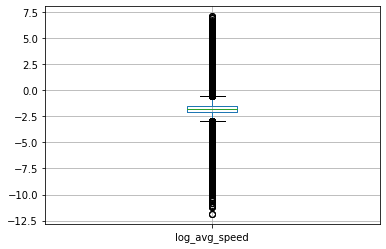

In [8]:
# All that's left to remove are massive outliers that don't really make sense logically. I mean, I'd love to travel at 1200 miles/minute,
# but unfortunately, they are the way they are becuse the data didn't record the trip distance or/and the trip duration properly.
pdf2["log_avg_speed"] = np.log(pdf2["avg_speed"])  # log transform to make the graph more readable
#pdf2
pdf2.boxplot(column=["log_avg_speed"])

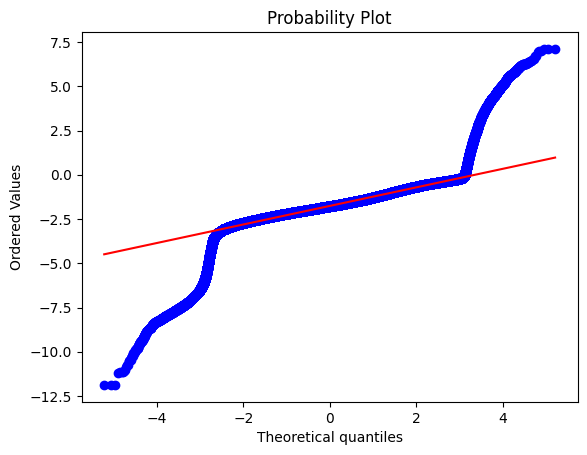

In [9]:
# After looking at the graph and converting the approximate average value to km/h, it is then starting to look logical with the 
# average speed value around 20km/h. Now, from here, although the IQR method to find outliers is not perfect,
# I'd say it is the best, fastest, and simplest method because the distribution of the data is unknown (no, the data is NOT
# normally distributed, proof below).
log_avg_speed = pdf2["log_avg_speed"].to_numpy()

from scipy import stats
import pylab

stats.probplot(log_avg_speed, dist="norm", plot=pylab)
pylab.show()

In [10]:
# drop since this one is not needed anymore
pdf2 = pdf2.drop(columns=["log_avg_speed"])

<AxesSubplot:>

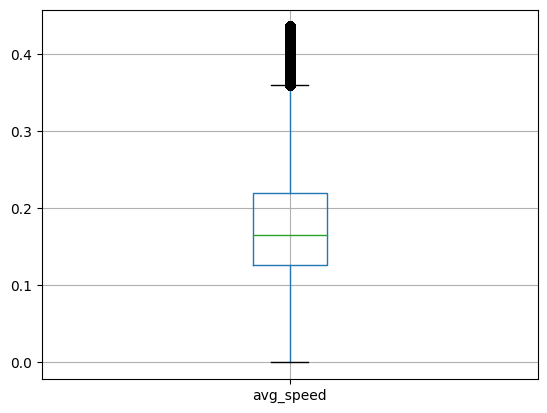

In [11]:
# find and remove outliers
q1 = pdf2["avg_speed"].quantile(0.25)
q3 = pdf2["avg_speed"].quantile(0.75)
iqr = q3 - q1

# I moved the threshold from 1.5 to 2 because if I don't, there are still values outside the range that are perfectly valid.
# i.e., when trips are 80km/h on a highway, the average speed will be much higher compared to non-highway trips.
pdf2 = pdf2[pdf2["avg_speed"] > q1 - 2 * iqr]
pdf2 = pdf2[pdf2["avg_speed"] < q3 + 2 * iqr]
pdf2.boxplot(column=["avg_speed"])

In [12]:
# the speed data for every nth minute in one day is going to be stored in a 2d list, consisting of 1440 * x elements.
# note: 1440 is the number of minutes in 24 hours, and x is the avg_speed data when (a) trip(s) occurs at the nth minute.

# ...
# Now I'm still only doing the January data, currently I'm 23 minutes in and Python is still not done processing the for loop. 
# The projected time for this loop to end is more than 30 minutes, which puts me at... *calculator noises* ...more than 6 hours to process
# all 12 months worth of dataset. Patience has a limit, am I right.
# I guess the only solution to this is to randomly sample the dataset by 1% or smaller, because this 
# current method seems like hell. I believe doing this on pyspark (instead of pandas) wouldn't help at all, 
# because it will still take a while to loop a bunch of commands 80 million times.
# ...

def calculate_speed(df):
    """
    This function calculates the average speed value given a dataframe, as explained in the green text above.
    Note that this function assumes that the average speed value is placed at the last column, the pick up time is placed
    at the first column, and the drop off time is placed at the second column of the dataframe.
    This function returns a two-dimensional list of speed data for every minute in one day, which is kinda awesome tbh.
    (Yes, I'm complimenting myself).
    """
    N_MIN = 1440

    # initialise list
    speed_data = []
    for i in range(N_MIN):
        speed_data.append([])

    # randomly sample the speed data
    df = df.sample(frac=0.005)

    # fill in the values
    for i in range(df.shape[0]):
        # the average speed value for the ith trip
        speed = df.iloc[i, -1]

        
        pu_day = df.iloc[i, 0].timetuple().tm_yday
        # pick up time, in the number of hours elapsed starting from 00:00
        pu_hour = df.iloc[i, 0].timetuple().tm_hour
        pu_min = df.iloc[i, 0].timetuple().tm_min
        pu_time = 60 * pu_hour + pu_min

        
        do_day = df.iloc[i, 1].timetuple().tm_yday
        # drop off time, in the number of hours elapsed starting from 00:00
        do_hour = df.iloc[i, 1].timetuple().tm_hour
        do_min = df.iloc[i, 1].timetuple().tm_min
        do_time = 60 * do_hour + do_min


        # if the trip starts at a particular day and ends at the next day
        if do_day < pu_day:
            do_time += N_MIN

        while pu_time <= do_time:
            if pu_time >= N_MIN:
                speed_data[pu_time - N_MIN].append(speed)
            else:
                speed_data[pu_time].append(speed)
            pu_time += 1

    return speed_data

# for example, in the 10th minute, the average speed is:
speed_data = calculate_speed(pdf2)
np.mean(speed_data[9])

0.22249097655730862

In [13]:
# Now do this for the entire 2019 data, instead of just January

# UPDATE: my laptop literally crashed while reading the datasets in, I guess they're just tooooooo big.
# I'll randomly sample the data by a third instead of reading everything in.
list_pdf = []
for dataset in range(1, 13):
    if dataset < 10:
        list_pdf.append(pd.read_parquet(f"../data/raw/yellow/2019-0{dataset}.parquet").sample(frac=0.33))
    else:
        list_pdf.append(pd.read_parquet(f"../data/raw/yellow/2019-{dataset}.parquet").sample(frac=0.33))
pdf = pd.concat([list_pdf[0], list_pdf[1], list_pdf[2], list_pdf[3], list_pdf[4], list_pdf[5], list_pdf[6], \
    list_pdf[7], list_pdf[8], list_pdf[9], list_pdf[10], list_pdf[11]])
pdf.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4859881,1,2019-01-21 07:15:17,2019-01-21 07:20:28,1.0,0.90,1.0,N,65,66,2,5.5,0.0,0.5,0.0,0.0,0.3,6.3,0.0,None
6697525,1,2019-05-28 15:11:49,2019-05-28 15:33:48,1.0,6.00,1.0,N,138,112,1,20.0,0.0,0.5,0.0,0.0,0.3,20.8,0.0,None
231409,2,2019-01-02 09:01:53,2019-01-02 09:09:36,1.0,1.27,1.0,N,141,263,2,7.0,0.0,0.5,0.0,0.0,0.3,7.8,NaN,None


In [14]:
# drop useless columns
pdf = pdf.drop(columns=["VendorID", "passenger_count", "RatecodeID", "store_and_fwd_flag", "payment_type", "fare_amount", "extra", \
    "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"])
# filter out non-2019 data
pdf = pdf[pdf["tpep_dropoff_datetime"] > datetime(2018, 12, 31)]
pdf = pdf[pdf["tpep_pickup_datetime"] < datetime(2020, 1, 1)]

# find out the trip duration
pdf["trip_duration"] = pdf["tpep_dropoff_datetime"] - pdf["tpep_pickup_datetime"]
# in minutes (float)
pdf["trip_duration"] = pdf["trip_duration"] / np.timedelta64(1, "m")

# calculate speed
pdf["avg_speed"] = pdf["trip_distance"] / pdf["trip_duration"]
pdf = pdf.sort_values("avg_speed", ascending=True)

# remove invalid values
pdf2 = pdf.copy()
pdf.replace([np.inf, -np.inf], np.nan, inplace=True)  # inf and -inf
pdf.dropna(subset=["avg_speed"], inplace=True)        # NaN
pdf = pdf[pdf["avg_speed"] > 0]                       # negative and 0 values

# find and remove outliers
q1 = pdf["avg_speed"].quantile(0.25)
q3 = pdf["avg_speed"].quantile(0.75)
iqr = q3 - q1

pdf = pdf[pdf["avg_speed"] > q1 - 2 * iqr]
pdf = pdf[pdf["avg_speed"] < q3 + 2 * iqr]

# and then, final step
speed_data = calculate_speed(pdf)

In [15]:
# create a new dataframe with two columns: the first one represent the nth minute in a day, 
# the second one represent the average speed with respect to that minute.
avg_speed_data = []
for i in range(len(speed_data)):
    avg_speed_data.append(np.mean(speed_data[i]))

speed_df = pd.DataFrame(avg_speed_data, columns=["avg_speed"])
speed_df.to_csv("../data/curated/speed.csv", index=True)